In [9]:
from qiskit import *
from qiskit.visualization import plot_histogram

import numpy as np

Key=QuantumRegister(8,'k')
IV=QuantumRegister(8,'iv')
IV1=QuantumRegister(8,'iv1')
Z=QuantumRegister(1,'z')
KS=QuantumRegister(2,'ks')
KS1=QuantumRegister(4,'ks1')
Out=QuantumRegister(1,'out')

C=ClassicalRegister(2,'c')
#C1=ClassicalRegister(29,'c1')

Grain=QuantumCircuit(Key,IV,IV1,Z,KS,KS1,Out,C)

#Tranforms the state of the system, applying X gates according to 0's in the vector 'state'
def X_Transformation(qc, qreg, state):
    
    for j in np.arange(len(state)):
        if( int(state[j])==0 ):
            qc.x( qreg[int(j)] )

#picks out the marked state and applies a negative phase
def Grover_Oracle(mark, qc, q, an1):
    qc.h( an1[0] )
    X_Transformation(qc, q, mark)
    if( len(mark) > 2 ):
        qc.mct ( q , an1[0] , None , 'noancilla' )
        #mct( q , an1[0])
    if( len(mark) == 2 ):
        qc.ccx( q[0], q[1], an1[0] )
    X_Transformation(qc, q, mark)
    qc.h( an1[0] )
    

#ammends the instructions for a Grover Diffusion Operation to the program    
def Grover_Diffusion(mark, qc, q, an1):
    zeros_state = []
    for i in np.arange( len(mark) ):
        zeros_state.append( 0 )
        qc.h( q[int(i)] )
    Grover_Oracle(zeros_state, qc, q, an1)
    for j in np.arange( len(mark) ):
        qc.h( q[int(j)] )


def KSA(IV,rnd):
    for t in range(rnd):
        Grain.reset(Z)

        #z=x2+x4+x7+y5+x4y2+x7y6
        Grain.ccx(Key[4],IV[2],Z)
        Grain.ccx(Key[7],IV[6],Z)
        for i in {2,4,7}:
               Grain.cx(Key[i],Z)
        Grain.cx(IV[5],Z)

        #g=x0+x2+x3+x3x5+x1x2+x4x6
        for i in {2,3}:
            Grain.cx(Key[i],Key[0])
        l=[3,1,4]
        m=[5,2,6]
        for i in range(3):
            Grain.ccx(Key[l[i]],Key[m[i]],Key[0])

        #x8=z+g+y0
        Grain.cx(Z,Key[0])
        Grain.cx(IV[0],Key[0])

        #f=y0+y1+y6+y7
        for i in {1,6,7}:
            Grain.cx(IV[i], IV[0])

        #y8=z+f
        Grain.cx(Z,IV[0])

        for i in range(7):
            Grain.swap(IV[i],IV[i+1])
            Grain.swap(Key[i],Key[i+1])
       
def PRGA(IV,length,KS):
    for j in range(length):
        Grain.reset(Z)
        Grain.ccx(Key[4],IV[2],Z)
        Grain.ccx(Key[7],IV[6],Z)
        for i in {2,4,7}:
               Grain.cx(Key[i],Z)
        Grain.cx(IV[5],Z)

        Grain.cx(Z,KS[j])

        for i in {2,3}:
            Grain.cx(Key[i],Key[0])
        l=[3,1,4]
        m=[5,2,6]
        for i in range(3):
            Grain.ccx(Key[l[i]],Key[m[i]],Key[0])
        Grain.cx(IV[0],Key[0])

        for i in {1,6,7}:
            Grain.cx(IV[i], IV[0])

        for i in range(7):
            Grain.swap(IV[i],IV[i+1])
            Grain.swap(Key[i],Key[i+1])
           
def PRGA_Inverse(IV,length,KS):
    for t in range(length):

        #beta=y0+y5+y6+y7
        Grain.cx(IV[0],IV[7])
        Grain.cx(IV[5],IV[7])
        Grain.cx(IV[6],IV[7])

        #alpha=beta+x1+x2+x7+x2x4+x0x1+x3x5
        Grain.cx(IV[7],Key[7])
        Grain.cx(Key[1],Key[7])
        Grain.cx(Key[2],Key[7])
        Grain.ccx(Key[2],Key[4],Key[7])
        Grain.ccx(Key[0],Key[1],Key[7])
        Grain.ccx(Key[3],Key[5],Key[7])

        for i in range(7):
            Grain.swap(IV[7-i],IV[6-i])
            Grain.swap(Key[7-i],Key[6-i])


def KSA_Inverse(IV,rnd):
    for t in range(rnd):
        #z=x1+x3+x6+y4+x3y1+x6y5
        Grain.reset(Z)
        for i in {1,3,6}:
            Grain.cx(Key[i],Z)    
        Grain.cx(IV[4],Z)
        Grain.ccx(Key[3],IV[1],Z)
        Grain.ccx(Key[6],IV[5],Z)

        #beta=z+y0+y5+y6+y7
        Grain.cx(IV[0],IV[7])
        Grain.cx(IV[5],IV[7])
        Grain.cx(IV[6],IV[7])
        Grain.cx(Z,IV[7])

        #alpha=z+beta+x1+x2+x7+x2x4+x0x1+x3x5
        Grain.cx(IV[7],Key[7])
        Grain.cx(Key[1],Key[7])
        Grain.cx(Key[2],Key[7])
        Grain.cx(Z,Key[7])
        Grain.ccx(Key[2],Key[4],Key[7])
        Grain.ccx(Key[0],Key[1],Key[7])
        Grain.ccx(Key[3],Key[5],Key[7])

        for i in range(7):
            Grain.swap(IV[7-i],IV[6-i])
            Grain.swap(Key[7-i],Key[6-i])





def BlackBox1():
    KSA(IV,16)
    PRGA(IV,2,KS)

def BlackBox1_Inv():
    PRGA_Inverse(IV,2,KS)
    KSA_Inverse(IV,16)
   
def BlackBox2():
    KSA_Inverse(IV,2)
    KSA(IV1,16)
    PRGA(IV1,4,KS1)

   
def BlackBox2_Inv():
    PRGA_Inverse(IV1,4,KS1)
    KSA_Inverse(IV1,16)
    KSA(IV,2)

#------------------------------------Grain Oracle----------------------------------------

def grain_oracle():
    BlackBox1()
    BlackBox1_Inv()
    BlackBox2()
    #XOR output of BlackBox1 with last two bits of BlackBox2
    for i in range(2):
        Grain.cx(KS[i],KS1[i+2])

def grain_oracle_inv():
    BlackBox2_Inv()

#-----------------------------------Secret Key------------------------------------------    
    
for i in range(8):    
    Grain.reset(Key[i])
#Key=11110001
for i in {0,4,5,6,7}:
    Grain.x(Key[i])
    
#--------------------------------------Inputs-------------------------------------------

    
#IV=10100001
for i in {0,5,7}:
    Grain.x(IV[i])

#IV1=100001**
for i in {2,7}:
    Grain.x(IV1[i])
for i in {0,1}:
    Grain.h(IV1[i])

    
#---------------------------------------------Attack------------------------------------      

Grain.x(Out[0])

for i in range(1):
    grain_oracle()
    
    Grain.h(Out[0])
    Grover_Oracle([0,0], Grain, [KS1[2],KS1[3]], Out)
    Grain.h(Out[0])
    
    grain_oracle_inv()
    
    for i in range(2):
        Grain.reset(KS[i])
    for i in range(4):
        Grain.reset(KS1[i])
    Grain.reset(Z)   
    
    Grover_Diffusion([0,0], Grain, [IV1[1],IV1[0]], Out)


# for i in range(8):
#     Grain.measure(Key[i],C1[i])
# for i in range(8):
#     Grain.measure(IV[i],C1[i+8])
# for i in range(6):
#     Grain.measure(IV1[i+2],C1[i+16])
# for i in range(2):
#     Grain.measure(KS[i],C1[i+22])
# for i in range(4):
#     Grain.measure(KS1[i],C1[i+24])
# Grain.measure(Z,C1[28])

for i in range(2):
    Grain.measure(IV1[i],C[i])
    

simulator = Aer.get_backend('qasm_simulator')
job = execute(Grain, simulator, shots=1024)
result = job.result()
counts = result.get_counts(Grain)
print(counts)
#plot_histogram(counts)


{'11': 163, '01': 185, '00': 204, '10': 472}


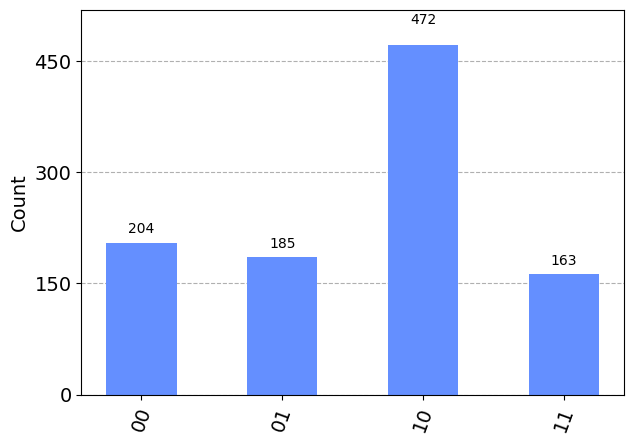

In [10]:
plot_histogram(counts)